In [4]:
import tensorflow as tf
import sys
from tensorflow import keras
from tensorflow.keras import backend as kb
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

In [5]:
def separateFairly(batchSize, numClasses):
    
    ratio = []
    for i in range(numClasses):
        ratio.append(batchSize//numClasses)
    
    choice = np.random.choice(numClasses, batchSize - sum(ratio), replace=False)
    
    for idx in choice:
        ratio[idx] += 1
    
    return ratio

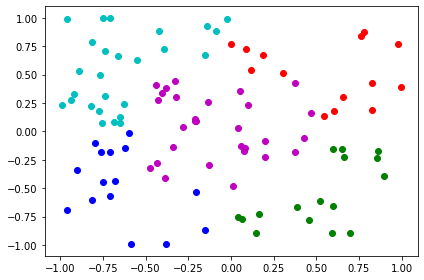

In [6]:
def DataGenerator(center, length, numberOfdata):
    
    fig = plt.figure()
    
    # inputs
    tmp = tf.random.uniform([numberOfdata, 2], maxval = length)
    a = tf.constant([[center[0] - length/2.0, center[1] - length/2.0]])
    b = tf.constant([numberOfdata,1])
    bias = tf.tile(a, b)
    inputs_ = tf.add(tmp, bias)
    # outputs
    outputs_ = np.zeros([numberOfdata])
    
    for idx, elem in enumerate(inputs_):
        if abs(elem[0] - center[0]) < length/4.0 and abs(elem[1] - center[1]) < length/4.0:
            plt.scatter(elem[0], elem[1], c='m')
            outputs_[idx] = 4
        elif elem[0] > center[0] and elem[1] > center[1]:
            plt.scatter(elem[0], elem[1], c='r')
            outputs_[idx] = 0
        elif elem[0] > center[0]:
            plt.scatter(elem[0], elem[1], c='g')
            outputs_[idx] = 1
        elif elem[0] <= center[0] and elem[1] <= center[1]:
            plt.scatter(elem[0], elem[1], c='b')
            outputs_[idx] = 2
        elif elem[0] <= center[0]:
            plt.scatter(elem[0], elem[1], c='c')
            outputs_[idx] = 3
    fig.tight_layout()
    plt.savefig('trainDataset.png')
    plt.show()
    
    return inputs_, outputs_


centerPoint = [0, 0]
length = 2
numOfPoint_total = 100

inputs_, outputs_ = DataGenerator(centerPoint, length, numOfPoint_total)

#print(inputs_.shape)
#print(outputs_.shape)


In [7]:
numberOfClasses = 5
batchsize = 16
numberOfBatches = 1000

buffer = []
for i in range(numberOfClasses):
    buffer.append(np.empty([1, 2]))
    
for idx, output_ in enumerate(outputs_):
    buffer[int(output_)] = np.concatenate((buffer[int(output_)], [inputs_[idx].numpy()]), axis=0)
    
for i in range(numberOfClasses):
    buffer[i] = np.delete(buffer[i], 0, axis=0)


inputs = np.empty([1, batchsize, 2])
outputs = np.empty([1, batchsize])

for i in range(numberOfBatches):
    
    ratio = separateFairly(batchsize, numberOfClasses)
    
    input_ = np.empty([1, 2])
    output_ = np.empty([1])
    
    for idx in range(numberOfClasses):  
        choice_idx = np.random.choice(buffer[idx].shape[0], ratio[idx], replace=False)
        chosen = buffer[idx][choice_idx]
        input_ = np.concatenate((input_, chosen), axis=0)
        
        tmp = np.empty(ratio[idx])
        tmp.fill(idx)
        output_ = np.concatenate((output_, tmp))
        
    input_ = np.delete(input_, 0, axis=0)
    output_ = np.delete(output_, 0, axis=0)
    
    input_ = np.expand_dims(input_, axis=0)
    output_ = np.expand_dims(output_, axis=0)
    
    inputs = np.concatenate((inputs, input_), axis=0)
    outputs = np.concatenate((outputs, output_), axis=0)
    
    #break
    
inputs = np.delete(inputs, 0, axis=0)
outputs = np.delete(outputs, 0, axis=0)

dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs)).shuffle(inputs.shape[0], reshuffle_each_iteration=True)
trainDataset = dataset.take(int(numberOfBatches * 0.7))
validDataset = dataset.skip(int(numberOfBatches * 0.7))

In [27]:
class MyModel(Model):
    def __init__(self, numFeatures):
        super(MyModel, self).__init__()
        self.architecture = [4]
        self.layers_custom = self.create_layers(self.architecture)
        self.lastLayer = Dense(numFeatures, activation='sigmoid')
        
    def create_layers(self, architecture):
        layers = []
        for units in self.architecture:
            layers.append(Dense(units, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(0.001)))
        return layers

    def call(self, x):
        for layer in self.layers_custom:
            x = layer(x)
        x = self.lastLayer(x)
        return x
    
    
class loss_L1(keras.losses.Loss):
    def __init__(self, name="custom"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        avgs = None
        
        for i in range(numberOfClasses):
            idx = tf.squeeze(tf.where(tf.equal(y_true, i)))
            tmp = tf.gather(y_pred, idx)
            avg = tf.reduce_mean(tmp, 0)
            
            if avgs is None:
                avgs = tf.expand_dims(avg, 0)
            else:
                avgs = tf.concat([avgs, tf.expand_dims(avg, 0)], 0)
                
        tmp = tf.math.reduce_std(avgs, 0)
        #L1 = 1 / tf.norm(tmp)
        
        L1 = 1 / (tf.norm(tmp) + kb.epsilon())
        #tf.print(L1, output_stream=sys.stderr)
        return L1
    
    
class loss_L2(keras.losses.Loss):
    def __init__(self, name="custom"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        stds = None
        
        for i in range(numberOfClasses):
            idx = tf.squeeze(tf.where(tf.equal(y_true, i)))
            tmp = tf.gather(y_pred, idx)
            std = tf.math.reduce_std(tmp, 0)
            
            if stds is None:
                stds = tf.expand_dims(std, 0)
            else:
                stds = tf.concat([stds, tf.expand_dims(std, 0)], 0)
                
        #tf.print(stds, output_stream=sys.stderr)
        
        tmp = tf.norm(stds, axis=1)
        #tf.print(tmp, output_stream=sys.stderr)
        L2 =  tf.math.reduce_sum(tmp)
        #tf.print(L2, output_stream=sys.stderr)
        
        return L2
    
class loss_L12(keras.losses.Loss):
    def __init__(self, name="custom"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        avgs = None
        stds = None
        
        for i in range(numberOfClasses):
            idx = tf.squeeze(tf.where(tf.equal(y_true, i)))
            tmp = tf.gather(y_pred, idx)
            avg = tf.reduce_mean(tmp, 0)
            std = tf.math.reduce_std(tmp, 0)
            
            if stds is None:
                avgs = tf.expand_dims(avg, 0)
                stds = tf.expand_dims(std, 0)
            else:
                avgs = tf.concat([avgs, tf.expand_dims(avg, 0)], 0)
                stds = tf.concat([stds, tf.expand_dims(std, 0)], 0)
        
        
        
        tmp = tf.math.reduce_std(avgs, 0)
        #tf.print(tmp, output_stream=sys.stderr)
        L1 = 1 / (tf.norm(tmp) + kb.epsilon())
        
        tmp = tf.norm(stds, axis=1)
        
        L2 =  tf.math.reduce_sum(tmp)
        
        #tf.print(L1, output_stream=sys.stderr)
        #tf.print(L2, output_stream=sys.stderr)
        
        loss = tf.math.add(L1, L2)
        
        #tf.print(tf.math.is_nan(loss), output_stream=sys.stderr)
        
        """
        if (tf.equal (tf.math.is_nan(loss), True) ):
            #print('y_true')
            tf.print(y_true, output_stream=sys.stderr)
            #print('y_pred')
            tf.print(y_pred, output_stream=sys.stderr)
            #tf.print(avgs, output_stream=sys.stderr)
            #tf.print(stds, output_stream=sys.stderr)
            #tf.print(loss, output_stream=sys.stderr)
        """
        
        return loss
    

model = MyModel(3)
L1 = loss_L1()
L2 = loss_L2()
L12 = loss_L12()

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
L1_train = tf.keras.metrics.Mean()
L2_train = tf.keras.metrics.Mean()  
@tf.function
def train_step(input_, output_):
    with tf.GradientTape() as tape:
        predictions = model(input_)
        l1 = L1(output_, predictions)
        l2 = L2(output_, predictions)
        Loss = L12(output_, predictions)
        
        
    gradients = tape.gradient(Loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    L1_train(l1)
    L2_train(l2)


L1_valid = tf.keras.metrics.Mean()
L2_valid = tf.keras.metrics.Mean()
@tf.function
def test_step(input_, output_):
    predictions = model(input_)
    
    l1 = L1(output_, predictions)
    l2 = L2(output_, predictions)

    L1_valid(l1)
    L2_valid(l2)

In [ ]:
EPOCHS = 1000
patience = 50
stopped_epoch = 0
best_weights = None
best = np.Inf
wait = 0

for epoch in range(EPOCHS):
    clear_output(wait=True)
    
    for input_, output_ in trainDataset:
        train_step(input_, output_)
        #break
    #break
    for input_, output_ in validDataset:
        test_step(input_, output_)
    
    template = '에포크: {}, L1_train: {:.4f}, L2_train: {:.3f}, L1_valid: {:.4f}, L2_valid: {:.3f}'
    print (template.format(epoch+1,
                         L1_train.result(),
                         L2_train.result(),
                         L1_valid.result(),
                         L2_valid.result()))
    
    if np.less(float(L1_valid.result() + L2_valid.result()), best):
        best = float(L1_valid.result() + L2_valid.result())
        best_weights = model.get_weights()
        wait = 0
    else:
        wait +=1
        if wait >= patience:
            model.set_weights(best_weights)
            stopped_epoch = epoch
            print('Early Stopped !')
            break

에포크: 95, L1_train: nan, L2_train: nan, L1_valid: nan, L2_valid: nan


In [ ]:
fig= plt.figure(figsize=(18,20))
ax = fig.add_subplot(111, projection='3d')


colors = ['r', 'g', 'b', 'c', 'm']
for idx in range(numberOfClasses):
    
    for input_ in buffer[idx]:
        
        tmp = np.expand_dims(np.array(input_), axis=0) 
        prediction = tf.squeeze(model(tmp)).numpy()
        
        ax.scatter(prediction[0], prediction[1], prediction[2], c=colors[idx])
        
        #print(prediction)
    